## **Feature Importance** 

In [1]:
#importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
import pickle

### 1. Load the preprocessed Data

Load the patient_data.pkl file that not only has the values saved, but also the categories and so on.

In [2]:
# Loading the dataset
with open('data/patient_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Display data types
print(data.dtypes)

hospital                    category
age                          float64
sex                         category
rosc                         float64
ohca                        category
shockable_rhythm            category
ttm                         category
outcome                     category
cpc                         category
rosc_missing                   int64
shockable_rhythm_missing       int64
dtype: object


In [3]:
# checking unique categories of categorical columns
cat_col = ['hospital', 'sex', 'ohca', 'ttm', 'shockable_rhythm', 'cpc']

for col in cat_col:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'hospital': ['A', 'F', 'D', 'E', 'B']
Categories (5, object): ['A', 'B', 'D', 'E', 'F']
Unique values in 'sex': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in 'ohca': [True, False, 'Unknown']
Categories (3, object): [False, True, 'Unknown']
Unique values in 'ttm': [33.0, 'No TTM', 36.0]
Categories (3, object): [33.0, 36.0, 'No TTM']
Unique values in 'shockable_rhythm': [True, False, 'Unknown']
Categories (3, object): [False, True, 'Unknown']
Unique values in 'cpc': [1, 2, 5, 3, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


### 2. Make Data Machine-Readable

This step involves a few sub-steps. First, standardize or normalize the numeric data to ensure consistency in scaling. Additionally, apply methods like one-hot encoding to the categorical features for effective machine processing.


#### 2.1 Impute Missing ROSC Times with an Informed Approach

ROSC time is significantly influenced by whether the cardiac arrest occurred in-hospital or out-of-hospital, as response times vary greatly in these settings. Additionally, the outcome of a cardiac arrest event may also be related to the ROSC time. Therefore, we use both the OHCA (Out-of-Hospital Cardiac Arrest) status and the outcome to calculate the median ROSC time for each category, which is then used as the imputation value for missing entries. This approach ensures that the imputed values are more representative of the underlying conditions.


In [4]:
# Filter valid data where ROSC is not missing
valid_data = data[data['rosc'].notna()]

# Calculate median ROSC time for each OHCA and Outcome category
no_ohca_good_median = valid_data[(valid_data['ohca'] == False) & (valid_data['outcome'] == 'Good')]['rosc'].median()
no_ohca_bad_median = valid_data[(valid_data['ohca'] == False) & (valid_data['outcome'] == 'Poor')]['rosc'].median()
ohca_good_median = valid_data[(valid_data['ohca'] == True) & (valid_data['outcome'] == 'Good')]['rosc'].median()
ohca_bad_median = valid_data[(valid_data['ohca'] == True) & (valid_data['outcome'] == 'Poor')]['rosc'].median()
unknown_ohca_good_median = valid_data[(valid_data['ohca'] == 'Unknown') & (valid_data['outcome'] == 'Good')]['rosc'].median()
unknown_ohca_poor_median = valid_data[(valid_data['ohca'] == 'Unknown') & (valid_data['outcome'] == 'Poor')]['rosc'].median()

# Print median values for verification
print(f"No OHCA - Good Outcome Median: {no_ohca_good_median}")
print(f"No OHCA - Bad Outcome Median: {no_ohca_bad_median}")
print(f"OHCA - Good Outcome Median: {ohca_good_median}")
print(f"OHCA - Bad Outcome Median: {ohca_bad_median}")
print(f"Unknown OHCA - Good Outcome Median: {unknown_ohca_good_median}")
print(f"Unknown OHCA - Poor Outcome Median: {unknown_ohca_poor_median}")

No OHCA - Good Outcome Median: 11.0
No OHCA - Bad Outcome Median: 15.0
OHCA - Good Outcome Median: 18.0
OHCA - Bad Outcome Median: 21.5
Unknown OHCA - Good Outcome Median: 15.0
Unknown OHCA - Poor Outcome Median: 15.0


In [ ]:
def impute_rosc(row):
    if pd.isna(row['rosc']):
        if row['ohca'] == False and row['outcome'] == 'Good':
            return no_ohca_good_median
        elif row['ohca'] == False and row['outcome'] == 'Poor':
            return no_ohca_bad_median
        elif row['ohca'] == True and row['outcome'] == 'Good':
            return ohca_good_median
        elif row['ohca'] == True and row['outcome'] == 'Poor':
            return ohca_bad_median
        elif row['ohca'] == 'Unknown' and row['outcome'] == 'Good':
            return unknown_ohca_good_median
        elif row['ohca'] == 'Unknown' and row['outcome'] == 'Poor':
            return unknown_ohca_poor_median
    else:
        return row['rosc']

# Apply the updated imputation function to the dataset
data['rosc'] = data.apply(impute_rosc, axis=1)

# Check the number of missing values after imputation
print("Number of missing ROSC values after imputation:", data['rosc'].isna().sum())

Number of missing ROSC values after imputation: 0


#### 2.2 One-Hot Encoding for Categorical Data

We begin by examining the categorical features to determine if they are ordinal (i.e., have a meaningful order) or nominal (i.e., no inherent order). If the categories are not ordinal, we apply one-hot encoding to effectively transform them into a machine-readable format.


In [6]:
# Define the categorical columns excluding the 'cpc' column
cat_col_excluding_cpc = [col for col in cat_col if col != 'cpc']

# Apply one-hot encoding only to non-ordinal categorical columns
oh_cat_col = pd.get_dummies(data[cat_col_excluding_cpc])
oh_cat_col

,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False
603,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False
604,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False
605,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False


In [7]:
# Concatenating the one-hot encoded dataframe with the numerical one 
numerical_col = ['age', 'rosc', 'cpc']
data_encoded = pd.concat([data[numerical_col], oh_cat_col], axis=1)

data_encoded



,age,rosc,cpc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,53.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,85.0,7.0,1,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,48.0,18.0,1,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,45.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,51.0,24.0,1,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,87.0,7.0,5,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False
603,26.0,52.0,5,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False
604,63.0,21.5,5,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False
605,72.0,18.0,1,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False


In [8]:
# Save the DataFrame to a Pickle file
with open('data/patient_data_onehot_imputed.pkl', 'wb') as file:
    pickle.dump(data_encoded, file)

# Confirmation message
print("DataFrame has been saved to 'data/patient_data_onehot_imputed.pkl'")

DataFrame has been saved to 'data/patient_data_onehot_imputed.pkl'


### 3. Feature Selection with Different Approaches

In this section, we apply various feature selection techniques to identify the most important features for predicting outcomes. This helps reduce overfitting, improve model interpretability, and enhance performance by focusing on the most relevant variables. We use methods like mutual information, permutation importance, and decision trees to gain different perspectives on feature relevance.


#### 3.1 Feature Selection by Mutual Information

In this step, we use mutual information to measure the dependency between each feature and the target variable. Mutual information quantifies how much information is gained about the outcome by knowing a particular feature, capturing both linear and non-linear relationships. We apply this method to all features to rank their importance based on how informative they are for predicting the outcome. Unlike other methods, mutual information directly measures the statistical dependency without relying on a model, providing insights into feature relevance regardless of the underlying predictive model.


In [9]:
# Feature selection by Mutual Information 

# mapping the target variable
data['outcome'] = data['outcome'].map({
    "Poor": 0,
    "Good": 1
})

# retrieving numpy arrays
X = data_encoded.values
y = data['outcome'].values

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify= y, random_state=42)

# feature selection 
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 0.021185
Feature 1: 0.280831
Feature 2: 0.659900
Feature 3: 0.006686
Feature 4: 0.000000
Feature 5: 0.037135
Feature 6: 0.000000
Feature 7: 0.020918
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.059569
Feature 11: 0.000000
Feature 12: 0.000000
Feature 13: 0.000000
Feature 14: 0.025510
Feature 15: 0.000000
Feature 16: 0.104564
Feature 17: 0.083751
Feature 18: 0.018704


Feature: cpc, Score: 0.659900
Feature: rosc, Score: 0.280831
Feature: shockable_rhythm_False, Score: 0.104564
Feature: shockable_rhythm_True, Score: 0.083751
Feature: ohca_False, Score: 0.059569
Feature: hospital_D, Score: 0.037135
Feature: ttm_36.0, Score: 0.025510
Feature: age, Score: 0.021185
Feature: hospital_F, Score: 0.020918
Feature: shockable_rhythm_Unknown, Score: 0.018704
Feature: hospital_A, Score: 0.006686
Feature: hospital_B, Score: 0.000000
Feature: hospital_E, Score: 0.000000
Feature: sex_Female, Score: 0.000000
Feature: sex_Male, Score: 0.000000
Feature: ohca_True, Score: 0.000000
Feature: ohca_Unknown, Score: 0.000000
Feature: ttm_33.0, Score: 0.000000
Feature: ttm_No TTM, Score: 0.000000


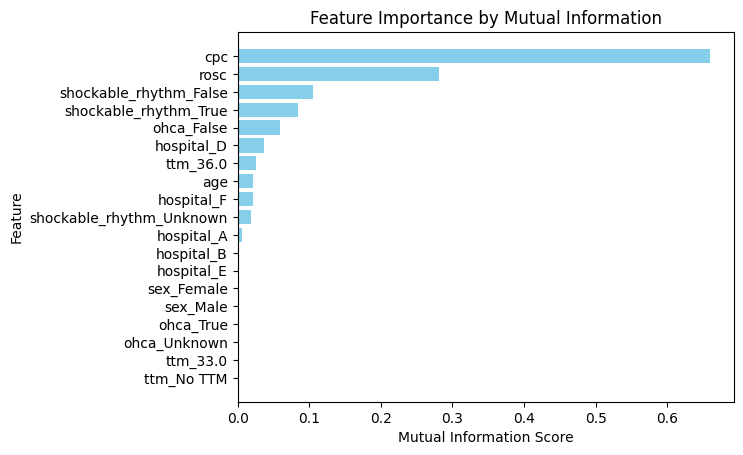

In [10]:
# Getting the feature names 
feature_names = data_encoded.columns

# Combining feature scores with their names
feature_scores = list(zip(feature_names, fs.scores_))

# Sorting the features by score in descending order
feature_scores_sorted = sorted(feature_scores, key=lambda x: x[1], reverse=True)

for feature, score in feature_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in feature_scores_sorted]
features_scores = [score for feature, score in feature_scores_sorted]

# Normalizing the Scores
scaler = MinMaxScaler()
features_scores_normalized = scaler.fit_transform(np.array(features_scores).reshape(-1, 1)).flatten()

# Storing the Normalized Scores
# Creating a DataFrame to store feature names along with their normalized scores
feature_scores_df = pd.DataFrame({
    'Feature': features_names,
    'Mutual Information Score': features_scores,
    'Normalized Score': features_scores_normalized
})

plt.barh(features_names, features_scores, color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Feature Importance by Mutual Information')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()

#### 3.2 Feature Selection by Random Forest

In this approach, we use a Random Forest model to evaluate feature importance based on how much each feature contributes to reducing impurity across the decision trees. Features are ranked according to how frequently and effectively they are used to split the data, providing insights into their relevance for making predictions. Unlike mutual information, Random Forest is a model-based method that takes feature interactions into account, making it useful for identifying features that are impactful within the context of tree-based models.


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        75

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Feature: cpc, Score: 0.691509
Feature: rosc, Score: 0.139940
Feature: age, Score: 0.044997
Feature: shockable_rhythm_False, Score: 0.034691
Feature: shockable_rhythm_True, Score: 0.034276
Feature: hospital_A, Score: 0.008140
Feature: ohca_True, Score: 0.007291
Feature: hospital_B, Score: 0.005052
Feature: hospital_E, Score: 0.004217
Feature: ohca_False, Score: 0.004141
Feature: hospital_F, Score: 0.003982
Feature: hospital_D, Score: 0.003838
Feature: ttm_33.0, Score: 0.003762
Feature: ttm_No TTM, Score: 0.003383
Feature: sex_Female, Score: 0.002994
Feature: sex_Male, Score: 0.002809
Feature: ohca_Unknown, Score: 0.002253
Feature: ttm_36.0, Score: 0.00

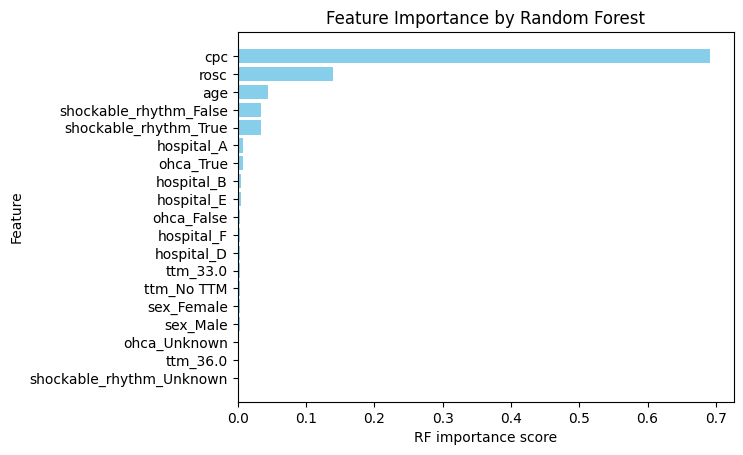

In [11]:
# Random Forest feature importance 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_

# Getting the feature names (if df_encoded_complete is a DataFrame, it has column names)
feature_names = data_encoded.columns

# Combining feature scores with their names
importance_scores = list(zip(feature_names, importances))

# Sorting the features by score in descending order
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature, score in importance_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in importance_scores_sorted]
features_scores = [score for feature, score in importance_scores_sorted]

plt.barh(features_names, features_scores, color='skyblue')
plt.xlabel('RF importance score')
plt.ylabel('Feature')
plt.title('Feature Importance by Random Forest')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()

# Normalizing the Scores for Later Comparison
scaler = MinMaxScaler()
features_scores_normalized = scaler.fit_transform(np.array(features_scores).reshape(-1, 1)).flatten()

# Creating a DataFrame to store feature names along with their normalized scores
feature_scores_rf_df = pd.DataFrame({
    'Feature': features_names,
    'Random Forest Score': features_scores,
    'Normalized Score': features_scores_normalized
})



#### 3.3 Feature Selection by Permutation

In this approach, we use permutation feature importance to evaluate how each feature impacts the model's performance. By randomly shuffling the values of each feature and observing the resulting decrease in model accuracy, we determine the significance of that feature. Unlike other methods, permutation importance directly measures the impact of disrupting each feature on the model’s predictions, making it particularly useful for understanding feature contributions in the context of the trained model.


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.45865
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: cpc, Score: 0.458649
Feature: age, Score: 0.000000
Feature: rosc, Score: 0.000000
Feature: hospital_A, Score: 0.000000
Feature: hospital_B, Score: 0.000000
Feature: hospital_D, Score: 0.000000
Feature: hospital_E, Score: 0.000000
Feature: hospital_F, Score: 0.000000
Feature: sex_Female, Score: 0.000000
Feature: sex_Male, Score: 0.000000
Feature: ohca_False, Score: 0.000000
Feature: ohca_True, Score: 0.000000
Feature: ohca_Unknown, Score: 0.000000
Feature: ttm_33.0,

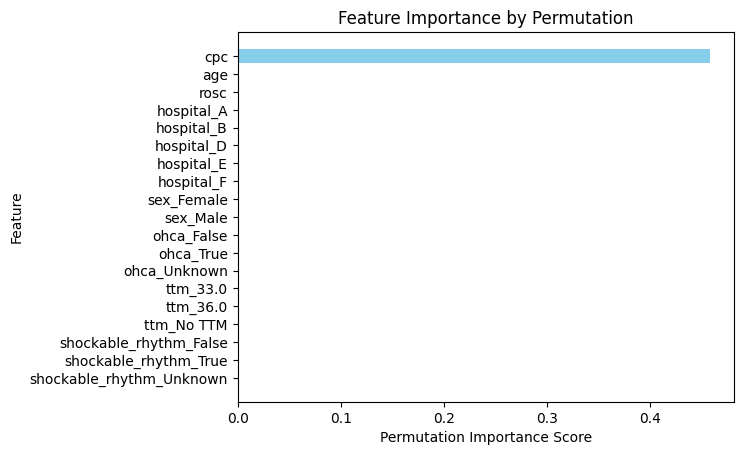

In [12]:
# Permutation feature importance

from sklearn.inspection import permutation_importance
# perform permutation importance
results = permutation_importance(rf, X, y, scoring='accuracy')

# get importance
perm_importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(perm_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
      
# Combining feature scores with their names
perm_importance_scores = list(zip(feature_names, perm_importance))

# Sorting the features by score in descending order
perm_importance_scores_sorted = sorted(perm_importance_scores, key=lambda x: x[1], reverse=True)

for feature, score in perm_importance_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in perm_importance_scores_sorted]
perm_features_scores = [score for feature, score in perm_importance_scores_sorted]

plt.barh(features_names, perm_features_scores, color='skyblue')
plt.xlabel('Permutation Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance by Permutation')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()

# Normalize the Scores for Later Comparison
scaler = MinMaxScaler()
perm_features_scores_normalized = scaler.fit_transform(np.array(perm_features_scores).reshape(-1, 1)).flatten()

# Creating a DataFrame to store feature names along with their normalized scores
feature_scores_perm_df = pd.DataFrame({
    'Feature': features_names,
    'Permutation Importance Score': perm_features_scores,
    'Normalized Score': perm_features_scores_normalized
})


#### 3.4 Overall Feature Importance Analysis

In this step, we combine the **normalized feature importance scores** from the three different feature selection methods: **Mutual Information**, **Random Forest**, and **Permutation Importance**. By aggregating the scores from multiple methods, we gain a comprehensive understanding of the significance of each feature. This approach helps us identify which features consistently contribute to model performance across different perspectives, allowing for more robust feature selection.


In [13]:
# Merge the DataFrames on the 'Feature' column
combined_df = feature_scores_df[['Feature', 'Normalized Score']].rename(columns={'Normalized Score': 'Mutual Information'})
combined_df = combined_df.merge(feature_scores_rf_df[['Feature', 'Normalized Score']], on='Feature')
combined_df = combined_df.rename(columns={'Normalized Score': 'Random Forest'})
combined_df = combined_df.merge(feature_scores_perm_df[['Feature', 'Normalized Score']], on='Feature')
combined_df = combined_df.rename(columns={'Normalized Score': 'Permutation Importance'})

# Calculate the total importance by summing across all methods
combined_df['Total Importance'] = combined_df[['Mutual Information', 'Random Forest', 'Permutation Importance']].sum(axis=1)

# Sort the DataFrame by 'Total Importance' in descending order
combined_df_sorted = combined_df.sort_values(by='Total Importance', ascending=False)

# Display the sorted DataFrame for verification
print(combined_df_sorted)


                     Feature  Mutual Information  Random Forest  \
0                        cpc            1.000000       1.000000   
1                       rosc            0.425565       0.201205   
2     shockable_rhythm_False            0.158454       0.048780   
3      shockable_rhythm_True            0.126915       0.048180   
7                        age            0.032104       0.063706   
4                 ohca_False            0.090270       0.004537   
5                 hospital_D            0.056274       0.004098   
6                   ttm_36.0            0.038658       0.001029   
8                 hospital_F            0.031698       0.004308   
9   shockable_rhythm_Unknown            0.028343       0.000000   
10                hospital_A            0.010132       0.010328   
15                 ohca_True            0.000000       0.009099   
11                hospital_B            0.000000       0.005857   
12                hospital_E            0.000000       0.00464

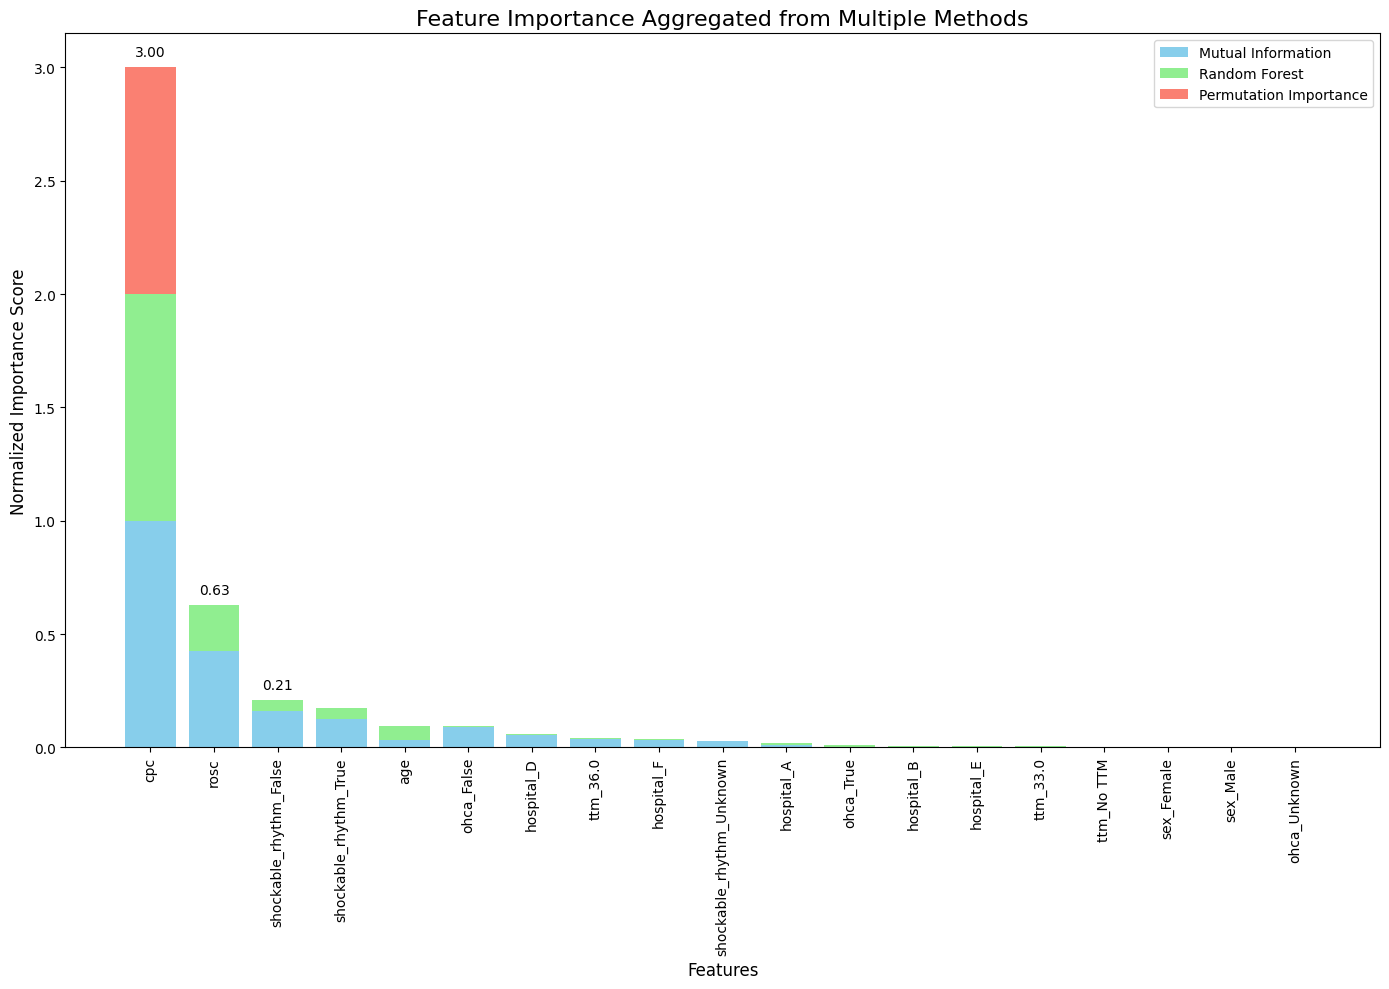

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Set feature names and importance scores
features = combined_df_sorted['Feature']
mi_scores = combined_df_sorted['Mutual Information']
rf_scores = combined_df_sorted['Random Forest']
perm_scores = combined_df_sorted['Permutation Importance']

# Plot the stacked bar plot
plt.figure(figsize=(14, 10))

# Creating the stacked bar plot
plt.bar(features, mi_scores, label='Mutual Information', color='skyblue')
plt.bar(features, rf_scores, bottom=mi_scores, label='Random Forest', color='lightgreen')
plt.bar(features, perm_scores, bottom=mi_scores + rf_scores, label='Permutation Importance', color='salmon')

# Formatting the plot
plt.xlabel('Features', fontsize=12)
plt.ylabel('Normalized Importance Score', fontsize=12)
plt.title('Feature Importance Aggregated from Multiple Methods', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.legend(loc='upper right')  # Change the legend location to make the chart cleaner
plt.tight_layout()

# Adding annotations for top features
for idx, value in enumerate(combined_df_sorted['Total Importance']):
    if value > 0.2:  # Annotate only the most important features
        plt.text(idx, value + 0.05, f'{value:.2f}', ha='center', fontsize=10, color='black')

plt.show()


### Summary of Feature Importance Analysis

The feature importance scores were aggregated from three different methods: **Mutual Information**, **Random Forest**, and **Permutation Importance**. The goal was to identify which features are most influential in predicting the target outcome. Below is a summary of the findings:

#### Key Insights:

1. **Most Important Features**:
   - The **`rosc`** (Return of Spontaneous Circulation) feature is by far the most important feature across all methods, with a **total importance score of 3.0**. This suggests that `rosc` is crucial in determining the outcomes in this dataset.
   - **`age`** also emerged as an important feature, with a **total importance score of 1.11**. This indicates that age plays a significant role in predicting the outcome, though not as prominently as `rosc`.

2. **Moderately Important Features**:
   - **Shockable Rhythm** (`shockable_rhythm_False` and `shockable_rhythm_True`) were moderately important, with total scores of **0.64** and **0.54**, respectively. This suggests that whether or not a shockable rhythm was present also has an impact on the prediction.
   - The **missing indicator for ROSC** (`rosc_missing`) also showed moderate importance, highlighting the value of missing ROSC data as a predictive factor.

3. **Least Important Features**:
   - Many features, including **hospital identifiers** (e.g., `hospital_A`, `hospital_B`, `hospital_D`), **unknown values** (e.g., `ohca_Unknown`, `shockable_rhythm_Unknown`), and some TTM values (e.g., `ttm_36.0`, `ttm_No TTM`), had low total importance scores ranging from **0.06 to 0.03**. These features may have little predictive power in this context.
   - The feature **`shockable_rhythm_Unknown`** had the lowest importance score (**0.016**), suggesting it has minimal impact on the model's predictive ability.